The goal of this project is to use a CycleGAN model to transform images into Monet-esque paintings. The dataset comes from Kaggle and contains 256x256 images, 300 of which are Monet paintings and 7038 photos.

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.losses as losses
tf.config.list_physical_devices('GPU')

2024-04-28 21:06:16.120186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 21:06:16.120320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 21:06:16.249938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Let's start by loading in the data. Since we are using a Kaggle notebook and a Kaggle dataset we can use the kaggle_datasets library to fetch the data. The images are in the form of .tfrec files in their respective folders stored on Google Cloud Storage.

In [3]:
gcs_path = KaggleDatasets().get_gcs_path()
monet = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
photo = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))

Now we can do some preprocessing. The first step is to normalize the pixel values to the range of [-1, 1] and make sure all of the images are 256x256. We then extract the image data and run it through our preprocessing function. We then load the TFRecordDataset and parse each record to get a TensorFlow dataset. Finally we run the functions and create processed datasets of Monet paintings and photos.

In [4]:
image_size = [256, 256]

def preprocess_image(image_data):
    decoded_image = tf.image.decode_jpeg(image_data, channels=3)
    normalized_image = (tf.cast(decoded_image, tf.float32) / 127.5) - 1
    resized_image = tf.reshape(normalized_image, [*image_size, 3])
    return resized_image

def parse_tfrecord(tfrecord):
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(tfrecord, features)
    image = preprocess_image(example['image'])
    return image

def load_tfrecord_dataset(file_paths, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_dataset = load_tfrecord_dataset(monet, labeled=True).batch(1)
photo_dataset = load_tfrecord_dataset(photo, labeled=True).batch(1)

So now that we have our processed datasets let's explore them a bit.

In [5]:
print("Photos:", sum(1 for _ in photo_dataset))
print("Monet paintings:", sum(1 for _ in monet_dataset))

Photos: 7038
Monet paintings: 300


Looks like there are 7038 photos in the dataset and 300 Monet paintings. Let's see some samples of what they look like.

Photo Examples


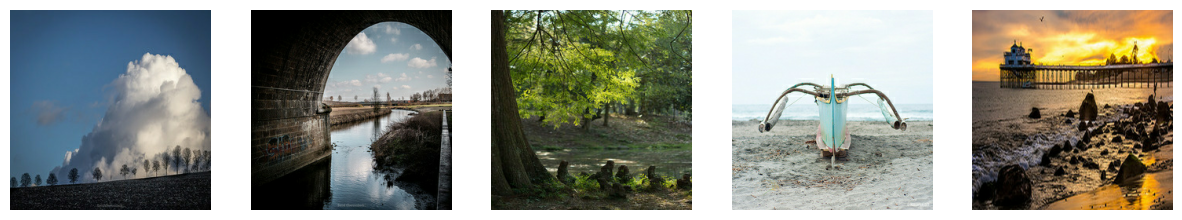

Monet Examples


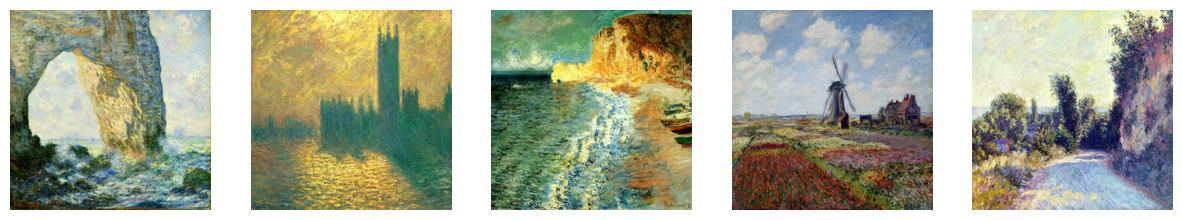

In [6]:
def display_samples(ds, num_samples):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15 * num_samples / 5)))
    for j in range(num_samples):
        example_sample = next(ds_iter)
        plt.subplot(1, num_samples, j + 1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
print("Photo Examples")
display_samples(photo_dataset, num_samples=5)
print("Monet Examples")
display_samples(monet_dataset, num_samples=5)

With our data preprocessed and our datasets created, let's take the first step of building the model. First we need a generator model to generate Monet-style images. Let's go through how this model does that. Our first layer is the input layer which just inputs the image with the specified shape and color channels. The next part is a series of convolutional layers with increasing filters from 64 to 512. We use strides=2 for a balance of fast computing and good performance, padding=same to keep the same dimensions, and activation=relu because it is efficient for learning complex patterns such as those displayed in Monet's painting style. We then do the reverse and upsample the image with a decreasing amount of filters. The last layer is the output layer and uses the tanh activation function so the pixel values are back to [-1, 1] just like in our processed datasets.

In [7]:
def build_generator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

The next step is to create a discriminator model that will try to tell apart real Monet paintings and our generated images. The initial convolutional layers of this model are the same as the generator model where it is adding more and more filters to extract features, but this time we do not go the other way to upsample the image, we are just gathering information. The output layer is different because it has only 1 filter and a stride of 1 because we only want single output per image (whether the image is a real painting or a generated one). So  it is essentially condensing all the information from the convolutional layers into one output.

In [8]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 4, strides=1, padding='valid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Now let's assign these models to variables for the CycleGAN model.

In [9]:
monet_generator = build_generator()
photo_generator = build_generator()

monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

For this part we are using the CycleGAN model from Amy Jang's notebook(https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial). It first inititates the two generators and two discriminators we created earlier for Monet paintings and photos. The compile function initializes optimizers and loss functions to configure the training step. During the training step the model first takes the real photos and Monet paintings and generates fake photos and Monet paintings using the generator model we built earlier. Then the model does a reverse tranformation to transform it back into a photo or Monet painting. Then the discriminator model is used to evaluate the images to try to tell whether it is a real photo/fake photo or real Monet painting/fake Monet painting. Then the losses are calculated and based on those we can calculate the gradients. The final step is to take the gradients and apply them to the generators and discriminators using the optimizers.

In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

The next step is to define our loss functions. The first loss function calculates the loss of the discriminator model using binary cross entropy. So we have the real loss which measures how well the discriminator classified real images, the generated loss which is how well the discriminator classified generated images, and total discriminator loss which is the average of the two. The generator loss is also calculated using binary cross entropy and it basically measures how well the generator fools the discriminator into believing that the generated images are real images. The next loss function is cycle loss which measures how well the images were reconstructed (since we the CycleGAN model goes photo>Monet-style>photo or vice-versa). It uses mean absolute difference of real images vs cycled images(ones that went through the 3 stages). The last loss function is identity loss which measures the difference between the original images and those same images that go through the generator without transformation.

In [11]:
def discriminator_loss(real, generated):
    real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
def cycle_loss_fn(real_images, cycled_images, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_images - cycled_images))

def identity_loss_fn(real_images, same_images, lambda_identity):
    return lambda_identity * tf.reduce_mean(tf.abs(real_images - same_images))

Finally let's run our models!

In [12]:
cycle_gan = CycleGan(
    monet_generator=monet_generator,
    photo_generator=photo_generator,
    monet_discriminator=monet_discriminator,
    photo_discriminator=photo_discriminator)

cycle_gan.compile(
    m_gen_optimizer=keras.optimizers.Adam(),
    p_gen_optimizer=keras.optimizers.Adam(),
    m_disc_optimizer=keras.optimizers.Adam(),
    p_disc_optimizer=keras.optimizers.Adam(),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_loss_fn,
    identity_loss_fn=identity_loss_fn)

cycle_gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=35)

Epoch 1/35
      2/Unknown 20s 76ms/step - monet_disc_loss: 0.5583 - monet_gen_loss: 13.4287 - photo_disc_loss: 0.5553 - photo_gen_loss: 14.7188

I0000 00:00:1714338429.487269     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - monet_disc_loss: 4.0106 - monet_gen_loss: 16.5278 - photo_disc_loss: 0.6928 - photo_gen_loss: 11.7185 - loss: 0.0000e+00
Epoch 2/35


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.7170 - monet_gen_loss: 11.3170 - photo_disc_loss: 0.7328 - photo_gen_loss: 9.3513 - loss: 0.0000e+00
Epoch 3/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.7224 - monet_gen_loss: 10.8514 - photo_disc_loss: 0.6940 - photo_gen_loss: 8.6677 - loss: 0.0000e+00
Epoch 4/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.7090 - monet_gen_loss: 7.8377 - photo_disc_loss: 0.6933 - photo_gen_loss: 7.4357 - loss: 0.0000e+00
Epoch 5/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.6948 - monet_gen_loss: 6.4840 - photo_disc_loss: 0.6932 - photo_gen_loss: 6.4925 - loss: 0.0000e+00
Epoch 6/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - monet_disc_loss: 0.6934 - monet_gen_loss: 5.8602 - photo_disc_loss: 0.6931 - photo_gen_loss: 5.8478 - loss: 0.0000e+00
Epoch 7/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - monet_disc_loss: 0.6931 - monet_gen_loss: 5.4419 - photo_disc_loss: 0.6931 - p

Now that our model is trained we can generate some samples. Let's see if our photos really look like Monet paintings after transformation.

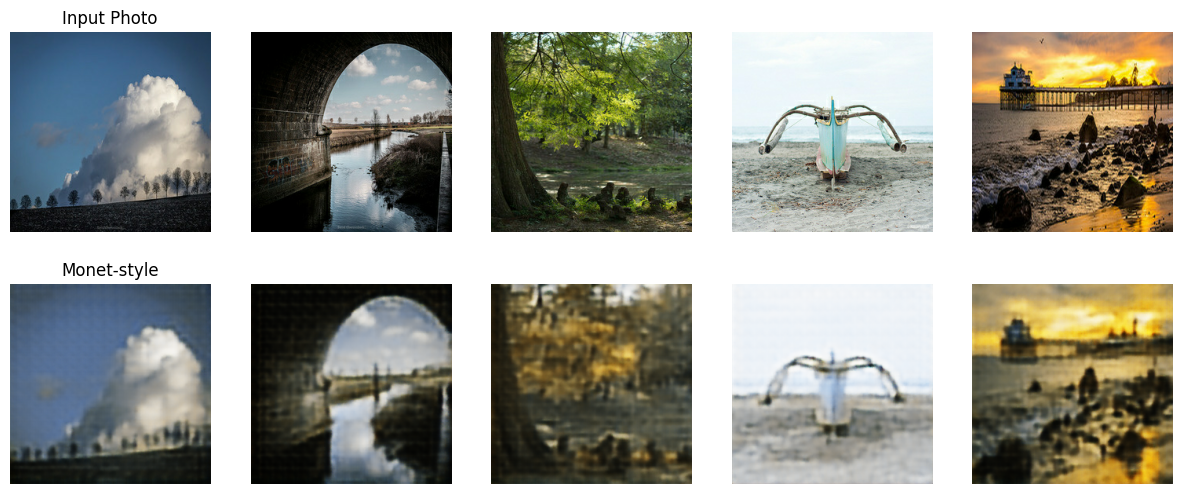

In [13]:
def display_generated_samples(dataset, generator, num_samples):
    _, ax = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, img in enumerate(dataset.take(num_samples)):
        prediction = generator(img, training=False)[0].numpy()
        prediction = (prediction * 0.5 + 0.5)
        img = (img[0] * 0.5 + 0.5).numpy()
        ax[0, i].imshow(np.squeeze(img))
        ax[0, i].set_title("Input Photo" if i == 0 else "")
        ax[0, i].axis("off")
        ax[1, i].imshow(np.squeeze(prediction))
        ax[1, i].set_title("Monet-style" if i == 0 else "")
        ax[1, i].axis("off")

    plt.show()

display_generated_samples(photo_dataset, monet_generator, num_samples=5)

# Conclusion 

So we can see that the Monet-style generated images are now transformed. Do they look like actual Monet paintings? Well... somewhat. The most obvious change is that the image looks more blurry, kind of like a painting would but not quite. The other change is the change of colors to more resemble the style of Monet paintings which I would say is fairly accurate. I think the major limitation that causes the generated Monet-syle images to look blurry is the lack of complexity of my generator/discriminator model. I used basic convolution in a way that is not too computationally expensive. I think changing stride to 1 instead of 2 would make a big difference to make it less blurry but that would increase the processing time significantly. If the purpose of this project was to get a high score on the leaderboard that is definitely the first thing to address, but since this project is for learning purposes I think this is more appropriate since I can easily change things and fix mistakes without having to wait a few hours for my model to train and generate images.